# Model Zoo -- Autoencoder

A simple, single-layer autoencoder that compresses 768-pixel MNIST images into 32-pixel vectors (32-times smaller representations).

In [33]:
!source /home/duanxin/miniconda3/etc/profile.d/conda.sh
!source activate

/bin/bash: activate: No such file or directory


In [38]:
!conda info | grep -i 'base environment'
!conda info --base
!export -f conda
!export -f __conda_activate
!export -f __conda_reactivate
!export -f __conda_hashr

       base environment : /home/duanxin/miniconda3  (writable)
/home/duanxin/miniconda3
/bin/bash: line 0: export: conda: not a function
/bin/bash: line 0: export: __conda_activate: not a function
/bin/bash: line 0: export: __conda_reactivate: not a function
/bin/bash: line 0: export: __conda_hashr: not a function


In [39]:
!source ~/miniconda3/etc/profile.d/conda.sh
!conda activate L16


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




## Imports

In [18]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import dataset.dataloader as VSD_dataset

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True


##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 5
batch_size = 256

# Architecture
num_features = 784
num_hidden_1 = 32


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset,val_dataset = VSD_dataset.get_dataset()


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=val_dataset,
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    img = images[0].squeeze()
    plt.imshow(img, cmap="gray")
    plt.show()
    break

ModuleNotFoundError: No module named 'cv2'

## Model

In [2]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        

    def forward(self, x):
        
        ### ENCODER
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        
        ### DECODER
        logits = self.linear_2(encoded)
        decoded = torch.sigmoid(logits)
        
        return decoded

    
torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [3]:
## Training

In [4]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 000/235 | Cost: 0.7098
Epoch: 001/005 | Batch 050/235 | Cost: 0.2097
Epoch: 001/005 | Batch 100/235 | Cost: 0.1602
Epoch: 001/005 | Batch 150/235 | Cost: 0.1373
Epoch: 001/005 | Batch 200/235 | Cost: 0.1269
Time elapsed: 0.08 min
Epoch: 002/005 | Batch 000/235 | Cost: 0.1194
Epoch: 002/005 | Batch 050/235 | Cost: 0.1110
Epoch: 002/005 | Batch 100/235 | Cost: 0.1079
Epoch: 002/005 | Batch 150/235 | Cost: 0.1037
Epoch: 002/005 | Batch 200/235 | Cost: 0.1031
Time elapsed: 0.16 min
Epoch: 003/005 | Batch 000/235 | Cost: 0.1022
Epoch: 003/005 | Batch 050/235 | Cost: 0.1025
Epoch: 003/005 | Batch 100/235 | Cost: 0.0992
Epoch: 003/005 | Batch 150/235 | Cost: 0.0955
Epoch: 003/005 | Batch 200/235 | Cost: 0.0964
Time elapsed: 0.23 min
Epoch: 004/005 | Batch 000/235 | Cost: 0.0986
Epoch: 004/005 | Batch 050/235 | Cost: 0.0964
Epoch: 004/005 | Batch 100/235 | Cost: 0.0988
Epoch: 004/005 | Batch 150/235 | Cost: 0.0973
Epoch: 004/005 | Batch 200/235 | Cost: 0.0931
Time elapse

## Evaluation

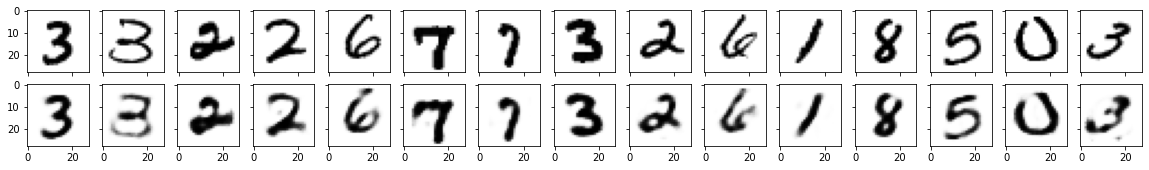

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

In [7]:
%watermark -iv

UsageError: Line magic function `%watermark` not found.
